# Modelo 3

### modelo de IA para prever série temporal

- Importando as bibliotecas

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit as MonteCarlo
from sklearn.preprocessing import MinMaxScaler

- Carregando o dataset

In [25]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


(None, None)

- Definindo as datas como indice

In [26]:
df['date'] = pd.to_datetime(df['date'])#, format='%d.%m.%Y %H:%M:%S')
df = df.set_index('date')

df_test['date'] = pd.to_datetime(df_test['date'])#, format='%d.%m.%Y %H:%M:%S')
df_test = df_test.set_index('date')

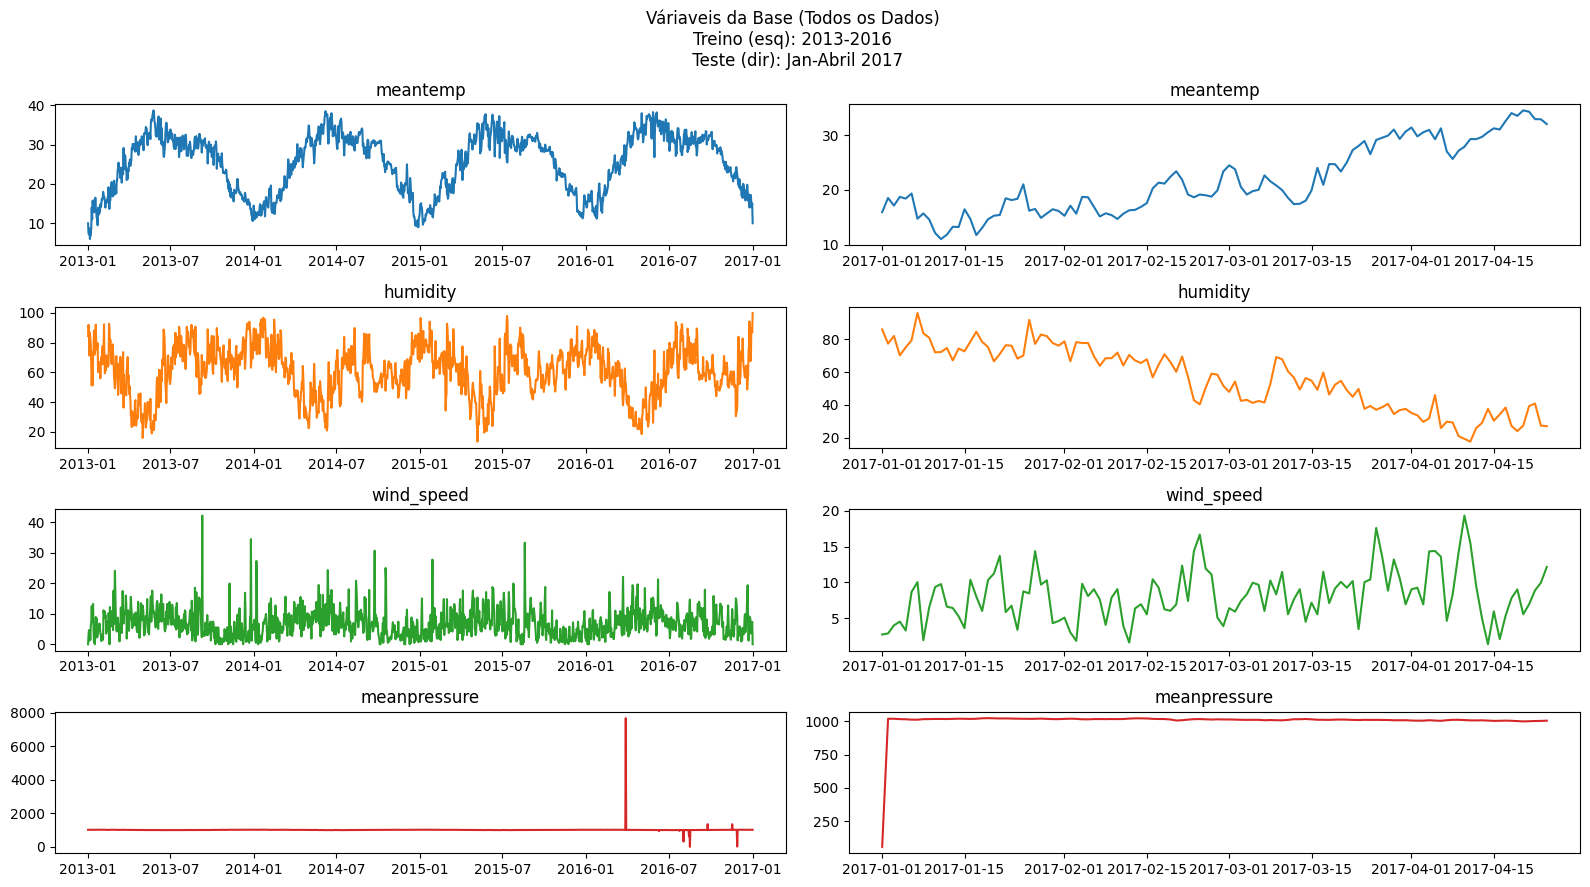

In [27]:
fig, ax = plt.subplots(len(df.columns),2,figsize=(16, 9))

for i,col in enumerate(df.columns):
    ax[i,0].plot(df[col],color=plt.cm.tab10(i))
    ax[i,0].title.set_text(col)
    ax[i,1].plot(df_test[col],color=plt.cm.tab10(i))
    ax[i,1].title.set_text(col)

fig.suptitle('Váriaveis da Base (Todos os Dados) \nTreino (esq): 2013-2016 \n Teste (dir): Jan-Abril 2017')
plt.tight_layout()


- É perceptível a presença de outliers para a pressão média

/tmp/ipykernel_19440/1354816544.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(cl1,
/tmp/ipykernel_19440/1354816544.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(cl2,


{'whiskers': [<matplotlib.lines.Line2D at 0x71db63d75e70>,
 'caps': [<matplotlib.lines.Line2D at 0x71db63d747f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x71db63d75570>],
 'medians': [<matplotlib.lines.Line2D at 0x71db63d758a0>],
 'fliers': [],
 'means': []}

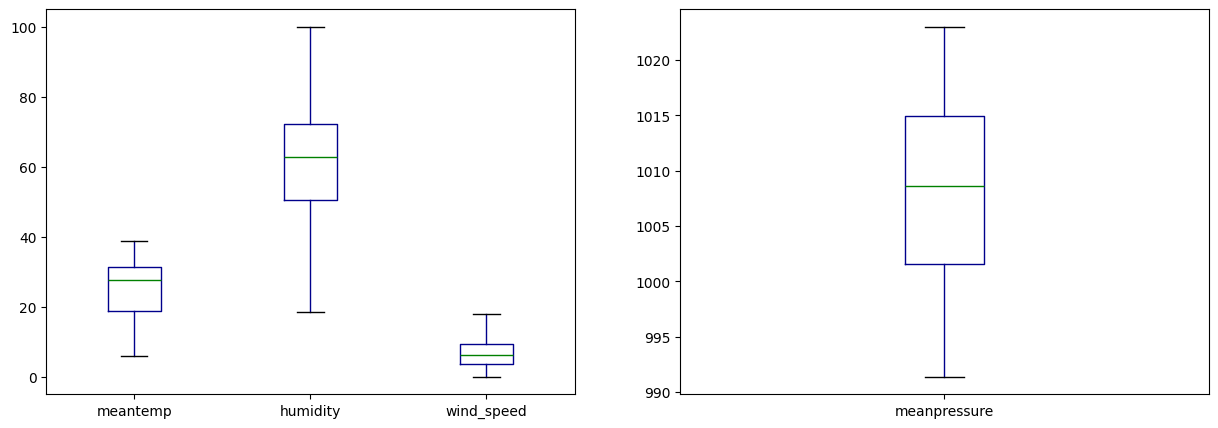

In [82]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
cl1 = df[list(df.columns)[:-1]]
cl2 = df[list(df.columns)[-1:]]
#plt.boxplot(cl1,)
ax1.boxplot(cl1,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl1.columns,showfliers=False)

ax2.boxplot(cl2,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl2.columns,showfliers=False)
#ax1.boxplot(df[list(df.columns)[:-1]],showfliers=False)
#ax2.boxplot(df[list(df.columns)[-1]],showfliers=False)

#df[list(df.columns)[:-1]].boxplot(showfliers=False)

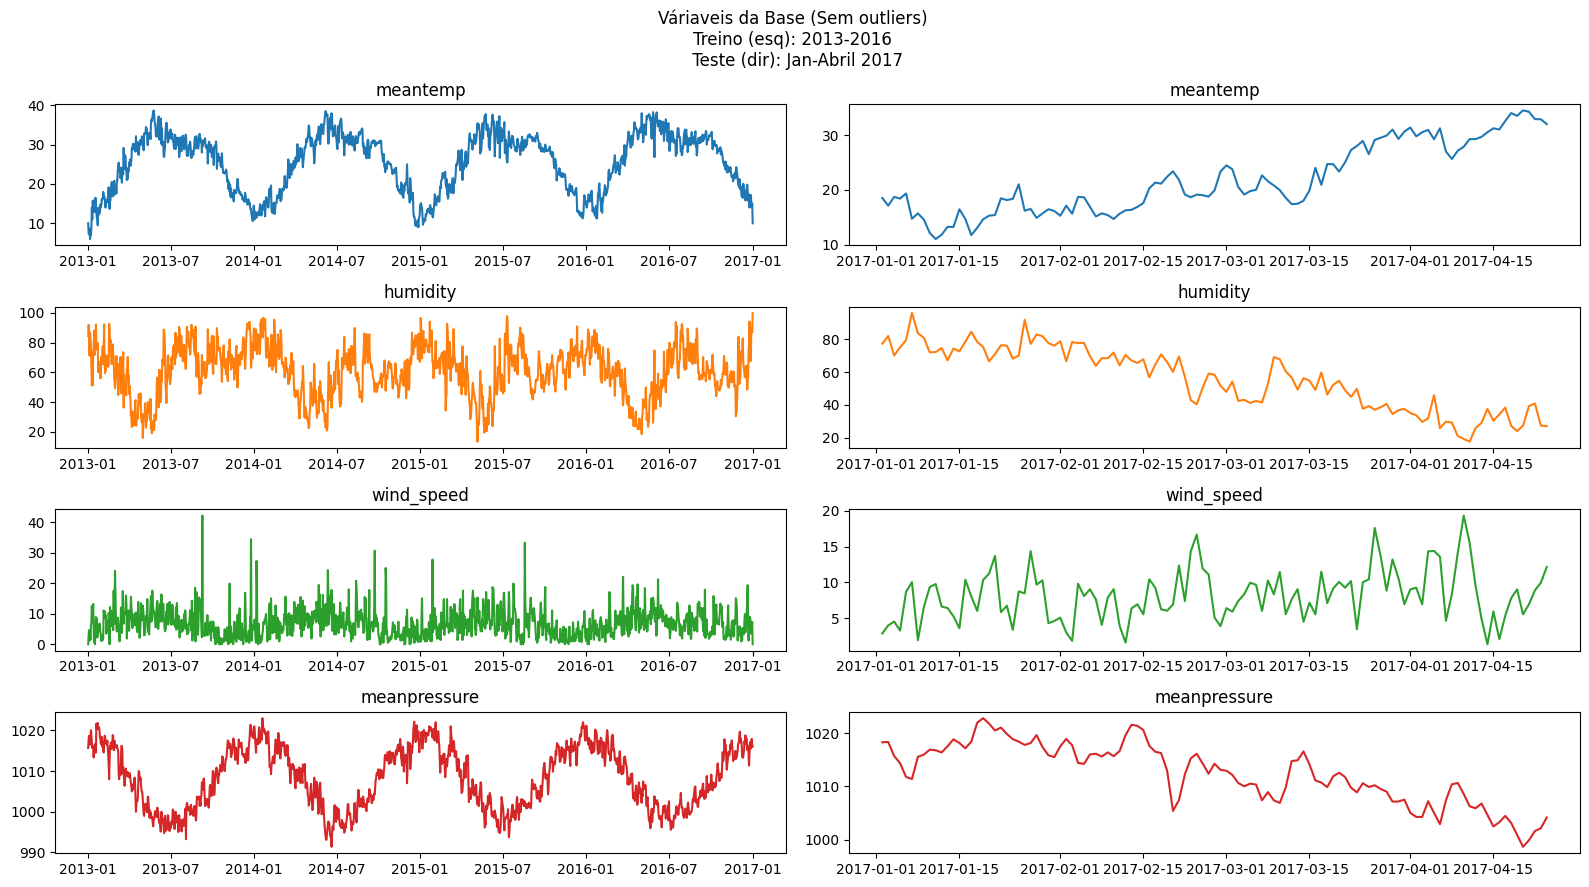

In [22]:
filters = []

for i, iter_df in enumerate([df,df_test]):
    Q1 = iter_df['meanpressure'].quantile(0.25)
    Q3 = iter_df['meanpressure'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (iter_df['meanpressure'] >= Q1 - 1.5 * IQR) & (iter_df['meanpressure'] <= Q3 + 1.5 *IQR)
    filters.append(filter)
    sml1 = iter_df.loc[filter]
    #sml1.plot(subplots=True)

fig, ax = plt.subplots(len(df.columns),2,figsize=(16, 9))

for i,col in enumerate(df.columns):
    ax[i,0].plot(df.loc[filters[0]][col],color=plt.cm.tab10(i))
    ax[i,0].title.set_text(col)
    ax[i,1].plot(df_test.loc[filters[1]][col],color=plt.cm.tab10(i))
    ax[i,1].title.set_text(col)
fig.suptitle('Váriaveis da Base (Sem outliers) \nTreino (esq): 2013-2016 \n Teste (dir): Jan-Abril 2017')
plt.tight_layout()

In [84]:
cl1 = np.abs(stats.zscore(df.meanpressure))
cl1

date
2013-01-01    0.025321
2013-01-02    0.037162
2013-01-03    0.041972
2013-01-04    0.033647
2013-01-05    0.029946
                ...   
2016-12-28    0.024758
2016-12-29    0.032193
2016-12-30    0.037743
2016-12-31    0.027726
2017-01-01    0.027171
Name: meanpressure, Length: 1462, dtype: float64

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

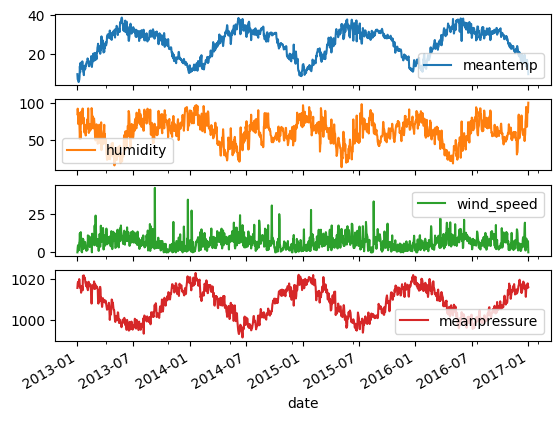

In [28]:
sml2 = df[
    #(np.abs(stats.zscore(df)) < 3).all(axis=1)
    (np.abs(stats.zscore(df.meanpressure)) < 0.359)
]
sml2.plot(subplots=True)

In [86]:
diff_size1 = pd.concat([sml1,sml2]).drop_duplicates(keep=False)
if diff_size1.__len__() == 0:
    print("nenhuma diferença no corte dos outliers em meantemperature")
else:
    print(diff_size1)

             meantemp    humidity  wind_speed  meanpressure
date                                                       
2017-01-02  18.500000   77.222222    2.894444   1018.277778
2017-01-03  17.111111   81.888889    4.016667   1018.333333
2017-01-04  18.700000   70.050000    4.545000   1015.700000
2017-01-05  18.388889   74.944444    3.300000   1014.333333
2017-01-06  19.318182   79.318182    8.681818   1011.772727
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1566 rows x 4 columns]


- Função para gerar as séries de predição

In [87]:
def create_features_labels(df, cols, window_size=7):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[cols].iloc[i:i+window_size].values.flatten())
        y.append(df[cols].iloc[i+window_size].values.flatten())
    return np.array(X), np.array(y)

- As variáveis de entrada são alocadas num vetor

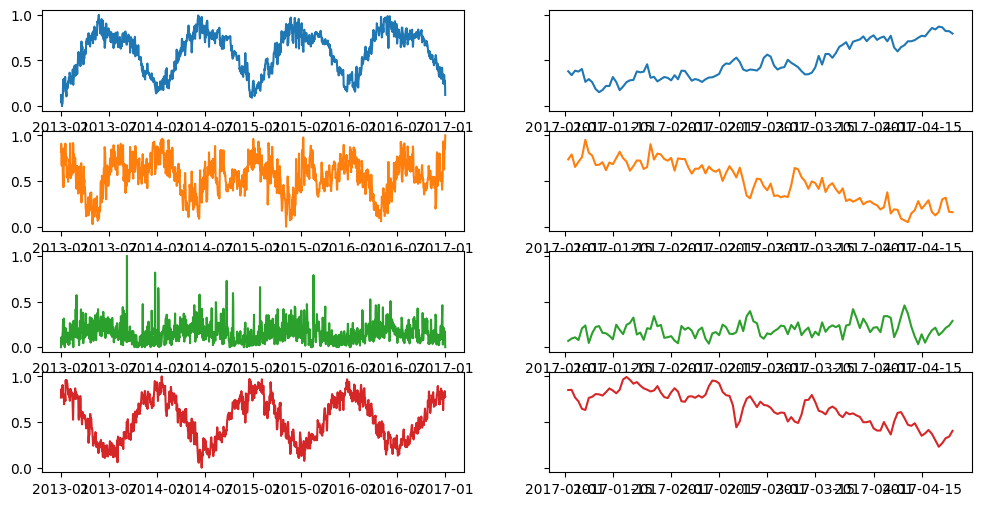

In [97]:
#Corte dos Outliers deve vir primeiro para não atrapalhar o scaler
scd_df_train  = df.loc[filters[0]].copy()
scd_df_test = df_test.loc[filters[1]].copy()

#Aplicacao do Scaler
scaler = MinMaxScaler()

scaler.fit(scd_df_train)
scd_df_train[scd_df_train.columns] = scaler.transform(scd_df_train)

scd_df_test[scd_df_test.columns] = scaler.transform(scd_df_test)


scd_df_train = scd_df_train.loc[filters[0]]
scd_df_test = scd_df_test.loc[filters[1]]

#Aplicacao 
fig, ax = plt.subplots(len(df.columns),2,figsize=(12, 6))

for i,col in enumerate(df.columns):
    ax[i,0].plot(scd_df_train[col],color=plt.cm.tab10(i))
    ax[i,1].plot(scd_df_test[col],color=plt.cm.tab10(i))

In [98]:
windows_size  = 7
n_variables = len(df.columns)

X_train, y_train = create_features_labels(scd_df_train, df.columns, window_size=windows_size)
X_test, y_test = create_features_labels(scd_df_test, df_test.columns, window_size=windows_size)
X_train[0], y_train[0]


(array([0.12227074, 0.8209571 , 0.        , 0.76811594, 0.04279476,
        0.90759076, 0.07058266, 0.83557312, 0.0356623 , 0.84983498,
        0.10974262, 0.8629776 , 0.08151383, 0.66886689, 0.02921206,
        0.81554677, 0.        , 0.84790979, 0.08763619, 0.7944664 ,
        0.03056769, 0.80132013, 0.03505448, 0.84189723, 0.03056769,
        0.75280528, 0.14921838, 0.90513834]),
 array([0.08733624, 0.58085809, 0.16918184, 0.86448334]))

In [99]:
n = windows_size*n_variables
windows_size, n_variables, n

(7, 4, 28)

- Modelagem

In [131]:
model = keras.Sequential()

#Camada de Input
model.add(
    keras.layers.Input((n,))
)
#Vamos manter a quantidade de neuronios proporcional ao número de entradas para facilitar o ajuste
model.add(
    keras.layers.Dense(
        16*n,
        activation='relu'
    )
)

model.add(
    keras.layers.Dense(8*n,activation='relu')
)

#Para última camada, é recomendado sigmoid
model.add(
    keras.layers.Dense(n_variables,activation='sigmoid')
)

In [132]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['r2_score']
)

In [136]:
#Define condição de parada extra: se tivermos 10 epocas sem melhora do r2 de teste paramos a execucao para evitar overfit
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=30, batch_size=10, callbacks=[callback])

Epoch 1/30


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - r2_score: 0.7501 - val_loss: 0.0056 - val_r2_score: 0.6079
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - r2_score: 0.7395 - val_loss: 0.0055 - val_r2_score: 0.6653
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - r2_score: 0.7454 - val_loss: 0.0059 - val_r2_score: 0.6229
Epoch 4/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0058 - r2_score: 0.7343 - val_loss: 0.0059 - val_r2_score: 0.6479
Epoch 5/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - r2_score: 0.7301 - val_loss: 0.0053 - val_r2_score: 0.6392
Epoch 6/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - r2_score: 0.7226 - val_loss: 0.0056 - val_r2_score: 0.6398
Epoch 7/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - r2_score: 0.7380 - val_loss: 0.0050 - val_r2_score: 0.6890
Epoch 8/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - r2_score: 0.7180 - val_loss: 0.0059 - val_r2_s

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])


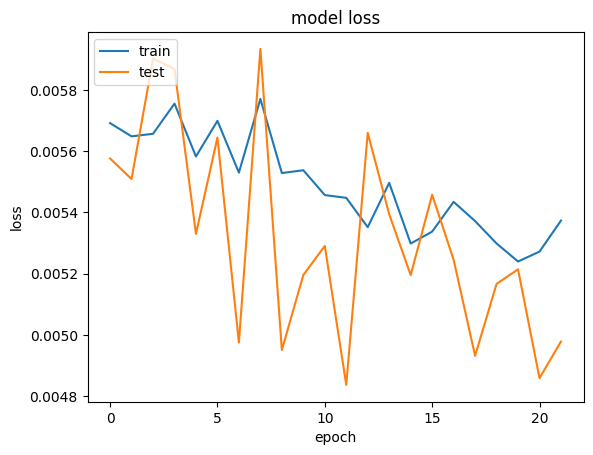

In [137]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])


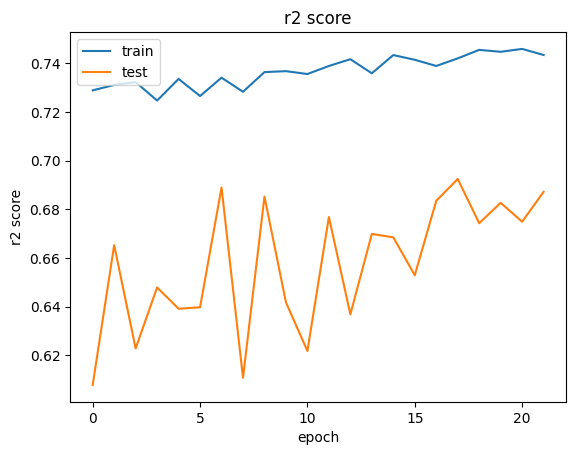

In [138]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('r2 score')
plt.ylabel('r2 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
y_pred = model.predict(X_test)

print(f'r²(total):{r2_score(y_test,y_pred):.3f}')

for i in range(4):
    print(f'r²({df.columns[i]}) = {r2_score(y_test[:,i], y_pred[:,i]):.3f}')

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
r²(total):0.687
r²(meantemp) = 0.902
r²(humidity) = 0.855
r²(wind_speed) = 0.095
r²(meanpressure) = 0.898
